# Data Science - Module 1 - Final Project Submission

* Student Name: **James Toop**
* Student Pace: **Self Paced**
* Scheduled project review date/time: **Thursday, 10th September 2020 - 3pm GMT**
* Instructor name: **Jeff Herman**
* Blog post URL: **TBC**

## Exploratory Data Analysis (EDA)

This notebook presents a more detailed investigation of the data, exploring a number of themes to aide business decision making as Microsoft ventures into the film industry. This report is by no means exhaustive and comes with certain caveats but serves as a preliminary discussion piece prior to more in-depth analysis.

The initial focus of the exploration is to quantify the opportunity to the business that the film industry represents and why, in an already crowded field, Microsoft should consider entering the market.

Further analysis looks to answer the direct question posed by the project brief, illustrating what _type of films are doing better at the box office_.  The project brief does not specify what denotes better box office performance so the EDA looks at a number of criteria that could reasonably constitute this.

The specific questions that have been posed and are answered through the visualisations are as follows:

1. [What is the size of the opportunity to the business? i.e. why we should venture into the film industry in the first place](#q1) 
2. [What is the potential return (and risk) on the investment? i.e. showing the profitability of film.](#q2)
3. [What is the relationship between production budget and profit? i.e. if you spend more do you make more](#q3)
4. [What is the relationship between audience ratings and box office income?](#q4)
5. [What types of films "perform" better than others?](#q5)
    1. [What genre of films are more popular than others?](#q5a)
    2. [Which experienced directors are the most popular, who should we work with?](#q5b)

In [42]:
# Import the relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import sqlite3
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Set styles and color palette for Seaborn
sns.set(font_scale=1.1)
pres_palette = ['#599191','#8dd8d3','#0b6374','#c0791b','#424242','#fd5b58','#d7e6a3','#d558ab','#27278b']
sns.set_palette(sns.color_palette(pres_palette))

---

<a name="q1"></a>
### 1. What is the size of the opportunity to the business? 

Why, in an already crowded field, should Microsoft consider entering into the film industry?

Between 2010 and 2018, gross income from film accounted for between 25 to 30 billion USD and is on an increasing trend.

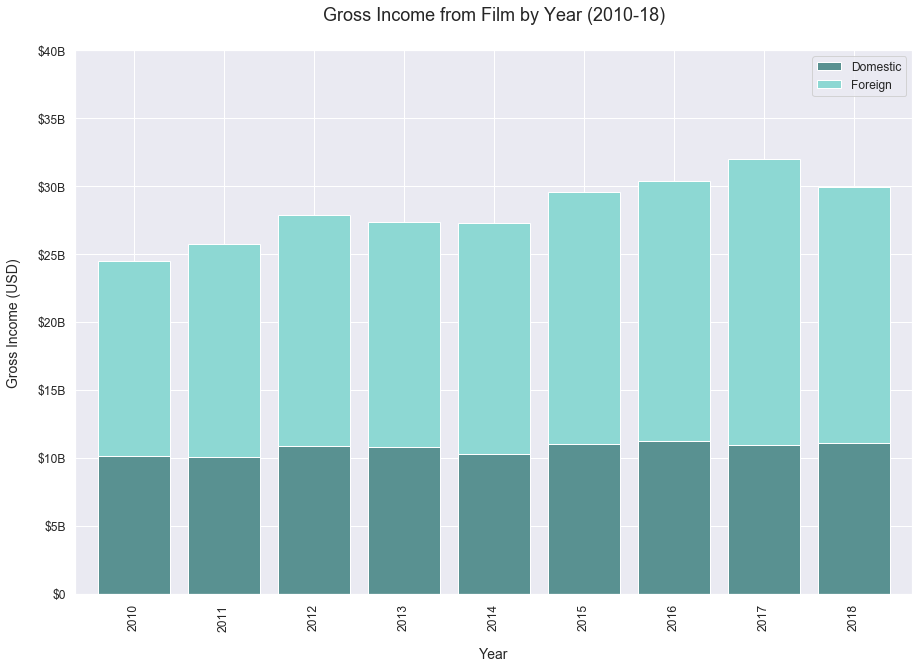

In [43]:
# Import the Box Office Mojo data
df_bom = pd.read_csv('zippedData/bom.movie_gross.csv.gz', compression='gzip', header=0, thousands=",")


# Handle missing values and datatypes to aide analysis
df_bom[['domestic_gross', 'foreign_gross']] = df_bom[['domestic_gross', 'foreign_gross']].fillna(0).astype(int)
df_bom[['year']] = df_bom[['year']].astype(str)


# Handle the incorrect foreign gross income data, out by a factor of 1,000,000 for the following films:
#  - The Fate of the Furious
#  - Jurassic World
#  - Star Wars: The Force Awakens
#  - Furious 7
#  - Avengers: Infinity War
df_bom.loc[df_bom.title.isin(['The Fate of the Furious',
                              'Jurassic World',
                              'Star Wars: The Force Awakens',
                              'Furious 7',
                              'Avengers: Infinity War'
                             ]) & (df_bom.foreign_gross < 1e6), 'foreign_gross'] = df_bom['foreign_gross'] * 1e6


# Handle any potential duplicates within the dataset based on film title and studio and sort by year
df_bom = df_bom.sort_values('year').drop_duplicates(subset=['title', 'studio'])


# Creating our first plot looking at Gross Income from Film year-on-year
existing_yvalues = [0,0.5e10,1e10,1.5e10,2e10,2.5e10,3e10,3.5e10,4e10]
readable_yvalues = ['$0','$5B','$10B','$15B','$20B','$25B','$30B','$35B','$40B']
q1_chart_data = df_bom[['year','domestic_gross','foreign_gross']].set_index('year').groupby('year').sum()
q1_chart_data.plot(kind='bar', stacked=True, figsize=(15,10), width=0.8)
plt.ylim(0,4e10)
plt.yticks(existing_yvalues, readable_yvalues)
plt.title('Gross Income from Film by Year (2010-18)', fontsize=18, pad=30)
plt.xlabel('Year', fontsize=14, labelpad=16)
plt.ylabel('Gross Income (USD)', fontsize=14, labelpad=16)
plt.legend(['Domestic','Foreign'])

plt.show()

---

<a name="q2"></a>
### 2. What is the potential return (and risk) on the investment? 

Generally speaking, there is a reasonable return on investment from making films with an average ROI of over 100% for the last 3 years up to 2018.

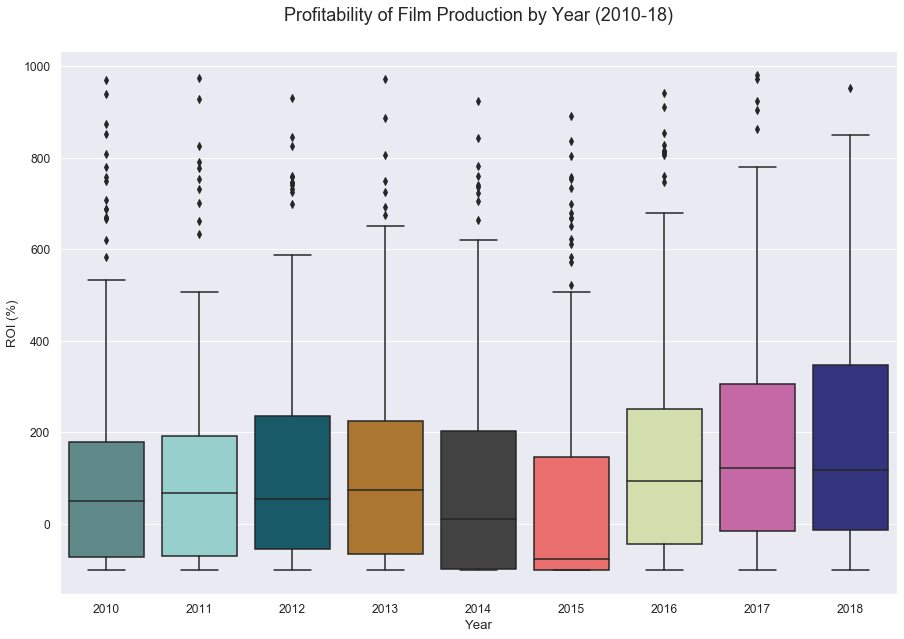

,id,release_year,production_budget,domestic_gross,worldwide_gross,profit,roi
count,2028.000000,2028.000000,2.028000e+03,2.028000e+03,2.028000e+03,2.028000e+03,2028.000000
mean,50.313116,2013.642012,3.708440e+07,4.250375e+07,1.083661e+08,7.128171e+07,113.629339
std,28.538398,2.435766,5.190507e+07,7.942022e+07,2.138880e+08,1.731455e+08,230.815307
min,1.000000,2010.000000,1.400000e+03,0.000000e+00,0.000000e+00,-1.104502e+08,-100.000000
25%,26.000000,2011.000000,4.500000e+06,6.115175e+04,8.407580e+05,-2.100000e+06,-81.597605
50%,50.000000,2014.000000,1.725000e+07,1.069289e+07,2.497419e+07,6.894652e+06,48.677469
75%,75.000000,2015.000000,4.212500e+07,5.050049e+07,1.051098e+08,6.329195e+07,216.823852
max,100.000000,2018.000000,4.106000e+08,9.366622e+08,2.053311e+09,1.748134e+09,979.457200


In [44]:
# Import TheNumbers - Movie Budgets dataset
df_tn_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz', compression='gzip', header=0)


# Remove text and convert datatypes to aide analysis
df_tn_budgets['production_budget'] = df_tn_budgets['production_budget'].str.replace('$', '')
df_tn_budgets['production_budget'] = df_tn_budgets['production_budget'].str.replace(',', '')
df_tn_budgets['production_budget'] = df_tn_budgets['production_budget'].astype(int)
df_tn_budgets['domestic_gross'] = df_tn_budgets['domestic_gross'].str.replace('$', '')
df_tn_budgets['domestic_gross'] = df_tn_budgets['domestic_gross'].str.replace(',', '')
df_tn_budgets['domestic_gross'] = df_tn_budgets['domestic_gross'].astype(int)
df_tn_budgets['worldwide_gross'] = df_tn_budgets['worldwide_gross'].str.replace('$', '')
df_tn_budgets['worldwide_gross'] = df_tn_budgets['worldwide_gross'].str.replace(',', '')
df_tn_budgets['worldwide_gross'] = df_tn_budgets['worldwide_gross'].astype(int)


# Add additional columns to the DataFrame for Release Year and Profit Margin
df_tn_budgets.insert(2, 'release_year', df_tn_budgets['release_date'].str[-4:].astype(int))
df_tn_budgets.insert(7, 'profit', (df_tn_budgets['worldwide_gross'] - df_tn_budgets['production_budget']))
df_tn_budgets.insert(8, 'roi', ((df_tn_budgets['profit'] / df_tn_budgets['production_budget'])*100).astype(float))


# Filter the dataframes to only show data between 2010 and 2018, remove outliers and sort by release year
df_tn_budgets = df_tn_budgets[(df_tn_budgets['release_year'] >=2010) & (df_tn_budgets['release_year'] <=2018)]
df_tn_budgets = df_tn_budgets[(df_tn_budgets['roi'] <= 1000) & 
                              (df_tn_budgets['roi'] >= -100)].sort_values('release_year')


# Creating a boxplot to show profitability of the film industry since 2010
plt.figure(figsize=(15,10))
plt.title('Profitability of Film Production by Year (2010-18)', fontsize=18, pad=30)
sns.boxplot(
    x=df_tn_budgets['release_year'],
    y=df_tn_budgets['roi'], 
    data=df_tn_budgets, 
    width=0.8, 
    palette=pres_palette).set(
    xlabel='Year', 
    ylabel='ROI (%)'
)

plt.show()

df_tn_budgets.describe()

---
<a name="#q3"></a>
### 3. What is the relationship between production budget and profit?

If you spend more on the film do you make more?

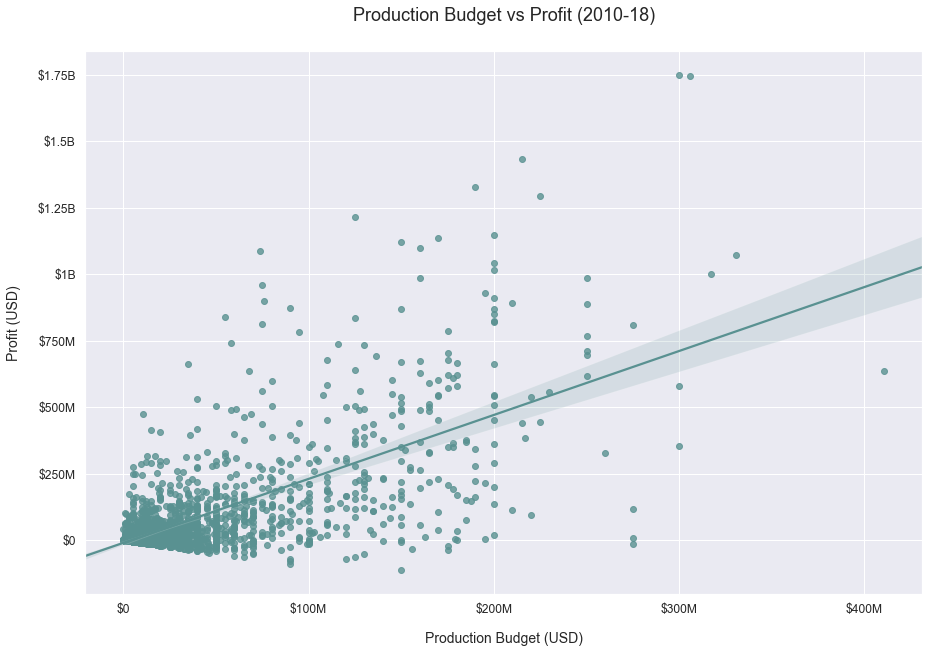

,id,release_year,production_budget,domestic_gross,worldwide_gross,profit
count,835.000000,835.000000,8.350000e+02,8.350000e+02,8.350000e+02,8.350000e+02
mean,49.413174,2013.604790,1.427044e+07,2.990843e+06,6.756884e+06,-7.513553e+06
std,28.343103,2.263669,2.407294e+07,7.815223e+06,1.865389e+07,1.110266e+07
min,1.000000,2010.000000,1.400000e+03,0.000000e+00,0.000000e+00,-1.104502e+08
25%,25.000000,2012.000000,1.200000e+06,0.000000e+00,0.000000e+00,-9.722362e+06
50%,49.000000,2014.000000,5.000000e+06,1.748400e+04,2.081630e+05,-3.459378e+06
75%,73.500000,2015.000000,1.800000e+07,1.312384e+06,5.074856e+06,-1.000000e+06
max,100.000000,2018.000000,2.750000e+08,8.930212e+07,2.600021e+08,-7.580000e+02


In [52]:
# Import TheNumbers - Movie Budgets dataset
df_film_profits = pd.read_csv('zippedData/tn.movie_budgets.csv.gz', compression='gzip', header=0)


# Remove text and convert datatypes to aide analysis
df_film_profits['production_budget'] = df_film_profits['production_budget'].str.replace('$', '')
df_film_profits['production_budget'] = df_film_profits['production_budget'].str.replace(',', '')
df_film_profits['production_budget'] = df_film_profits['production_budget'].astype(int)
df_film_profits['domestic_gross'] = df_film_profits['domestic_gross'].str.replace('$', '')
df_film_profits['domestic_gross'] = df_film_profits['domestic_gross'].str.replace(',', '')
df_film_profits['domestic_gross'] = df_film_profits['domestic_gross'].astype(int)
df_film_profits['worldwide_gross'] = df_film_profits['worldwide_gross'].str.replace('$', '')
df_film_profits['worldwide_gross'] = df_film_profits['worldwide_gross'].str.replace(',', '')
df_film_profits['worldwide_gross'] = df_film_profits['worldwide_gross'].astype(int)


# Add additional columns to the DataFrame for Release Year and Profit Margin
df_film_profits.insert(2, 'release_year', df_film_profits['release_date'].str[-4:].astype(int))
df_film_profits.insert(7, 'profit', (df_film_profits['worldwide_gross'] - df_film_profits['production_budget']))


# Filter the dataframes to only show data between 2010 and 2018, remove outliers and sort by release year
df_film_profits = df_film_profits[(df_film_profits['release_year'] >=2010) 
                                & (df_film_profits['release_year'] <=2018)]
df_film_profits = df_film_profits[df_film_profits['production_budget'] > 0]

# Creating a regplot to show variation of production budget against profit
existing_xvalues = [0,1e8,2e8,3e8,4e8]
existing_yvalues = [0.00,0.25e9,0.5e9,0.75e9,1.00e9,1.25e9,1.50e9,1.75e9]
readable_xvalues = ['$0','$100M','$200M','$300M','$400M']
readable_yvalues = ['$0','$250M','$500M','$750M','$1B','$1.25B','$1.5B','$1.75B']
plt.figure(figsize=(15,10))
plt.title('Production Budget vs Profit (2010-18)', fontsize=18, pad=30)

q3_chart = sns.regplot(
            x=df_film_profits['production_budget'],
            y=df_film_profits['profit'],
            data=df_film_profits
) 

plt.xticks(existing_xvalues, readable_xvalues)
plt.xlabel('Production Budget (USD)', fontsize=14, labelpad=16)
plt.yticks(existing_yvalues, readable_yvalues)
plt.ylabel('Profit (USD)', fontsize=14, labelpad=16)

plt.show()

df_film_losses = df_film_profits[(df_film_profits['profit'] < 0)]
df_film_losses.describe()

---
<a name="q4"></a>
### 4. What is the relationship between audience ratings and box office income?



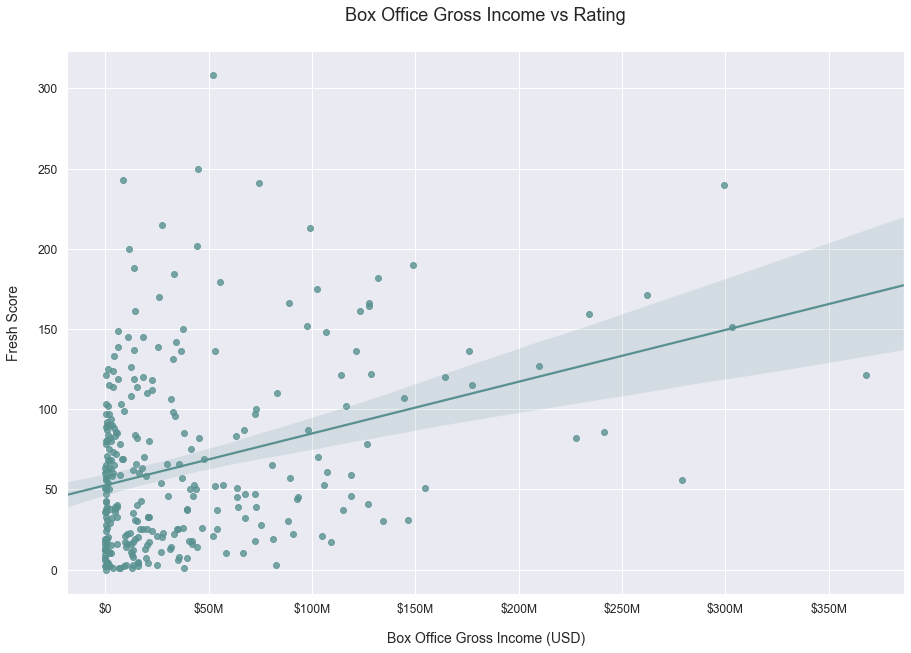

In [46]:
# Importing the csv files from Rotten Tomatoes - N.B. tab separated
df_rotten_films = pd.read_csv(
    'zippedData/rt.movie_info.tsv.gz', 
    compression='gzip', 
    header=0, sep='\t', 
    encoding= 'unicode_escape'
)

df_rotten_reviews = pd.read_csv(
    'zippedData/rt.reviews.tsv.gz', 
    compression='gzip', 
    header=0, 
    sep='\t', 
    encoding= 'unicode_escape'
)


# Filter all rows where a Box Office figure is available, greater than zero and convert box office datatype
df_rotten_films = df_rotten_films[df_rotten_films['box_office'].notna()]
df_rotten_films['box_office'] = df_rotten_films['box_office'].str.replace(',', '')
df_rotten_films['box_office'] = df_rotten_films['box_office'].astype(int)
df_rotten_films = df_rotten_films[df_rotten_films['box_office'] > 0]


# Convert the rating into a score and aggregate for each film
df_rotten_reviews['fresh_score'] = np.where(df_rotten_reviews['fresh']!= 'rotten', 1, 0)
df_rotten_reviews = df_rotten_reviews.groupby('id')[['fresh_score']].sum()


# Merge the two dataframes together
df_rotten_scores = pd.merge(df_rotten_films, df_rotten_reviews, left_on='id', right_on='id', how='left')


# Filter all rows where no rating / fresh score is available
df_rotten_scores = df_rotten_scores[df_rotten_scores['fresh_score'].notna()]


# Creating a regplot to show variation of production budget against profit
existing_xvalues = [0,0.5e8,1e8,1.5e8,2e8,2.5e8,3e8,3.5e8]
readable_xvalues = ['$0','$50M','$100M','$150M','$200M','$250M','$300M','$350M']
plt.figure(figsize=(15,10))
plt.title('Box Office Gross Income vs Rating', fontsize=18, pad=30)

q4_chart = sns.regplot(
            x=df_rotten_scores['box_office'],
            y=df_rotten_scores['fresh_score'],
            data=df_rotten_scores
) 

plt.xticks(existing_xvalues, readable_xvalues)
plt.xlabel('Box Office Gross Income (USD)', fontsize=14, labelpad=16)
plt.ylabel('Fresh Score', fontsize=14, labelpad=16)

plt.show()

---
<a name="q5"></a>
### 5. What types of films "perform" better than others?

<a name="q5a"></a>
#### 5A. What genre of films are more popular than others?

[TheMovieDB.org popularity calculation](https://developers.themoviedb.org/3/getting-started/popularity)

In [34]:
# Create / connect to the TMDB database
conn = sqlite3.connect('tmdb-films.db')
c = conn.cursor()


In [15]:
# Create [tmdb_films] table
c.execute('''CREATE TABLE tmdb_films (
[genre_ids] text,
[id] integer PRIMARY KEY,
[original_language] text,
[original_title] text,
[popularity] float,
[release_date] text,
[title] text,
[vote_average] float,
[vote_count] integer
)''')


# Create [tmdb_genres] table
c.execute('''CREATE TABLE tmdb_genres (
[genre_id] integer PRIMARY KEY,
[genre] text
)''')
          
conn.commit()


# Import TMDB dataset dropping the first, extraneous column and de-duping based on film title and ID
read_tmdb_films = pd.read_csv('zippedData/tmdb.movies.csv.gz', compression='gzip', header=0)
read_tmdb_films.drop('Unnamed: 0', axis=1, inplace=True)
read_tmdb_films.sort_values('id', inplace=True)
read_tmdb_films.drop_duplicates(subset=['id'], keep='first', inplace=True)
read_tmdb_films.to_sql('tmdb_films', conn, if_exists='append', index = False)

read_tmdb_genres = pd.read_csv('zippedData/tmdb.movie_genres.csv.gz', compression='gzip', header=0)
read_tmdb_genres.to_sql('tmdb_genres', conn, if_exists='append', index = False)

In [35]:
def get_films_by_genre(genre):
    
    """Return dataframe for average popularity for a specific genre."""
    
    c.execute('''
    SELECT
    ? AS `genre`,
    AVG(`films`.`popularity`) AS `average_popularity`
    FROM `tmdb_films` `films`
    WHERE SUBSTR(`films`.`release_date`,1,4) IN ('2010','2011','2012','2013','2014','2015','2016','2017','2018')
    AND EXISTS (
    SELECT `genre_id` 
    FROM `tmdb_genres`
    WHERE `films`.`genre_ids` LIKE '%' || genre_id || '%'
    AND `genre` = ?)
    ;''', genre)
    
    df = pd.DataFrame(c.fetchall())
    df.columns = [x[0] for x in c.description]

    return df


# Load each list of films by genre into an individual dataframe.  
# This deliberately duplicates films into multiple dataframes as we're looking at genre popularity

df_action = get_films_by_genre(['Action','Action'])
df_adventure = get_films_by_genre(['Adventure','Adventure'])
df_animation = get_films_by_genre(['Animation','Animation'])
df_comedy = get_films_by_genre(['Comedy','Comedy'])
df_crime = get_films_by_genre(['Crime','Crime'])
df_documentary = get_films_by_genre(['Documentary','Documentary'])
df_drama = get_films_by_genre(['Drama','Drama'])
df_family = get_films_by_genre(['Family','Family'])
df_fantasy = get_films_by_genre(['Fantasy','Fantasy'])
df_history = get_films_by_genre(['History','History'])
df_music = get_films_by_genre(['Music','Music']) 
df_mystery = get_films_by_genre(['Mystery','Mystery'])
df_romance = get_films_by_genre(['Romance','Romance'])
df_scifi = get_films_by_genre(['Science Fiction','Science Fiction'])
df_thriller = get_films_by_genre(['Thriller','Thriller'])
df_war = get_films_by_genre(['War','War'])
df_western = get_films_by_genre(['Western','Western'])

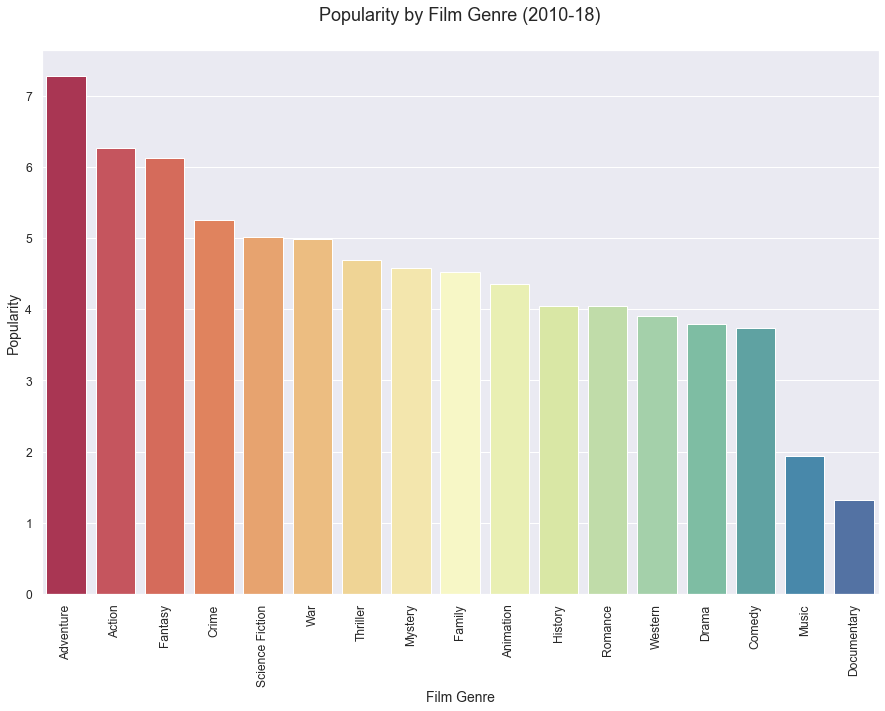

In [47]:
#Combine all the genre specific dataframes into one.
genres = [df_action, 
          df_adventure, 
          df_animation, 
          df_comedy, 
          df_crime,
          df_documentary,
          df_drama,
          df_family,
          df_fantasy,
          df_history,
          df_music,
          df_mystery,
          df_romance,
          df_scifi,
          df_thriller,
          df_war,
          df_western
         ]
all_genres = pd.concat(genres)
all_genres.set_index('genre')


# Sort the dataframe in order of decreasing average popularity
all_genres = all_genres.sort_values('average_popularity', ascending=False)


plt.figure(figsize=(15,10))
plt.title('Popularity by Film Genre (2010-18)', fontsize=18, pad=30)
q5a_chart = sns.barplot(
    x=all_genres['genre'],
    y=all_genres['average_popularity'], 
    data=all_genres, 
    palette='Spectral')

q5a_chart.set_xlabel('Film Genre', fontsize=14)
q5a_chart.set_ylabel('Popularity', fontsize=14)
q5a_chart.set_xticklabels(q5a_chart.get_xticklabels(), rotation=90)

plt.show()

<a name="q5b"></a>
#### 5B. Which experienced directors are the most popular, who should we work with?

In [48]:
# Importing the relevant data from IMDb
df_imdb_basics = pd.read_csv('zippedData/imdb.title.basics.csv.gz', compression='gzip', header=0)
df_imdb_ratings = pd.read_csv('zippedData/imdb.title.ratings.csv.gz', compression='gzip', header=0)
df_imdb_principals = pd.read_csv('zippedData/imdb.title.principals.csv.gz', compression='gzip', header=0)
df_imdb_names = pd.read_csv('zippedData/imdb.name.basics.csv.gz', compression='gzip', header=0)


# Join the basics dataframe with ratings dataframe
df_imdb_films  = df_imdb_basics.set_index('tconst').join(df_imdb_ratings.set_index('tconst'))


# Merge the principals dataframe with names dataframe and filter for Directors only
df_imdb_directors = pd.merge(df_imdb_principals, df_imdb_names, left_on='nconst', right_on='nconst', how='left')
df_imdb_directors = df_imdb_directors[df_imdb_directors['category'] == 'director']


# Remove all titles with no rating and that was released between 2010 and 2018 for consistency
df_imdb_films = df_imdb_films[df_imdb_films['averagerating'].notna()]
df_imdb_films = df_imdb_films[(df_imdb_films['start_year'] >= 2010) & (df_imdb_films['start_year'] <= 2018)]


# Filter out all titles of less that 70 minutes in length and with at least 100 votes or more
df_imdb_films = df_imdb_films[df_imdb_films['runtime_minutes'] >= 70]
df_imdb_films = df_imdb_films[df_imdb_films['numvotes'] >= 100]


# Merge the films dataframe with the directors dataframe
df_imdb_top_directors = pd.merge(df_imdb_films, df_imdb_directors, left_on='tconst', right_on='tconst', how='left')


# Filter out films with no director information and those directors that are no longer alive
df_imdb_top_directors = df_imdb_top_directors[df_imdb_top_directors['category'].notna()]
df_imdb_top_directors = df_imdb_top_directors[df_imdb_top_directors['death_year'].isna()]


# Filter out the specific columns that we need to create the visualisation and find the mean average rating
df_director_scores = df_imdb_top_directors[['nconst','primary_name','averagerating']].copy()
df_director_scores = df_director_scores.groupby(['nconst', 'primary_name'])[['averagerating']].mean().reset_index()


# Find the number of films that the director is credited for
df_film_number = df_imdb_top_directors['nconst'].value_counts().rename_axis('nconst').reset_index(name='no_of_films')


# Merge the number of films with the mean of the average rating
df_top_directors = pd.merge(df_director_scores, df_film_number, left_on='nconst', right_on='nconst', how='left')
df_top_directors.dropna(axis=0, inplace=True)

# Filter the dataframe to only show directors who have directed 5 or more films and then sort by averagerating
df_top_directors = df_top_directors[df_top_directors['no_of_films'] >= 5]
df_top_directors.sort_values(['averagerating'], ascending=False, inplace=True)
df_top_directors.head(15)



,nconst,primary_name,averagerating,no_of_films
12277,nm2829542,Paul Dugdale,7.933333,6
5449,nm0898288,Denis Villeneuve,7.800000,6
16,nm0000217,Martin Scorsese,7.657143,7
5943,nm1011775,Keitarô Motonaga,7.640000,5
9952,nm1999473,Shoojit Sircar,7.640000,5
9646,nm1907554,Kaushik Ganguly,7.633333,9
7587,nm1365879,Morgan Neville,7.616667,6
3451,nm0542498,Mahesh Manjrekar,7.580000,5
94,nm0000965,Danny Boyle,7.580000,5
9638,nm1905310,Jeff Zimbalist,7.560000,5
